<a href="https://colab.research.google.com/github/zvyag/PyTorch-for-Deep-Learning-and-Computer-Vision-Course-All-Codes-/blob/master/pytorch_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install torch torchvision

In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch import nn

In [0]:
transform = transforms.Compose([transforms.Resize((28, 28)), 
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])
training_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=100, shuffle=False)

In [0]:
def im_convert(tensor):
  image = tensor.clone().detach().numpy()
  image = image.transpose(1, 2, 0)  # change the shape (1, 28, 28) -> (28, 28, 1)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

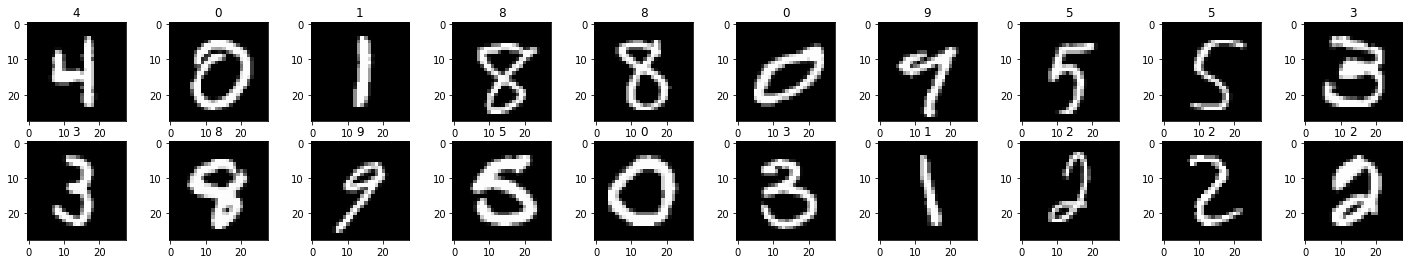

In [5]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1)
  plt.imshow(im_convert(images[idx]))
  ax.set_title(labels[idx].item())

In [0]:
class Classifier(nn.Module):
  
  def __init__(self, D_in, H1, H2, D_out):
    super().__init__()
    self.linear1 = nn.Linear(D_in, H1)
    self.linear2 = nn.Linear(H1, H2)
    self.linear3 = nn.Linear(H2, D_out)
    
  def forward(self, x):
    x = F.relu(self.linear1(x))
    x = F.relu(self.linear2(x))
    x = self.linear3(x)  # no activation function here, the output is not binary!
    return x

In [0]:
class LeNet(nn.Module):
  
  def __init__(self):
    super().__init__()
    nn.Conv2d(1, 20, 5, 1)

In [0]:
??nn.Conv2d()

In [7]:
model = Classifier(784, 125, 65, 10)
model

Classifier(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [0]:
criterion = nn.CrossEntropyLoss()  # used for multiclass classification
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [0]:
def compute_loss(inputs, labels):
  inputs = inputs.view(inputs.shape[0], -1)
  outputs = model(inputs)  
  return criterion(outputs, labels), outputs

In [10]:
epochs = 12
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for i in range(epochs):
  
  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0
  
  for train_in, train_label in training_loader:
    loss, out = compute_loss(train_in, train_label)  # loss computed on one batch
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    _, preds = torch.max(out, 1)    
    running_loss += loss.item()
    running_corrects += torch.sum(preds == train_label.data)  # number of correct predictions in each batch
  else:
    with torch.no_grad():  # to save memory
      for val_in, val_labels in validation_loader:
        val_loss, val_out = compute_loss(val_in, val_labels)
        
        _, val_preds = torch.max(val_out, 1)    
        val_running_loss += val_loss.item()
        val_running_corrects += torch.sum(val_preds == val_labels.data)  # number of correct predictions in each batch
      
    epoch_loss = running_loss / len(training_loader)
    epoch_acc = running_corrects.float() / len(training_loader)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)
    
    val_epoch_loss = val_running_loss / len(validation_loader)
    val_epoch_acc = val_running_corrects.float() / len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)
    
    print("epoch: ", i)
    print("training loss: {:.4f}, acc: {:.4f}".format(epoch_loss, epoch_acc.item()))
    print("validation loss: {:.4f}, val acc: {:.4f}".format(val_epoch_loss, val_epoch_acc.item()))

epoch:  0
training loss: 0.4298, acc: 87.6700
validation loss: 0.2721, val acc: 91.7700
epoch:  1
training loss: 0.2205, acc: 93.2933
validation loss: 0.1791, val acc: 94.5200
epoch:  2
training loss: 0.1601, acc: 95.1500
validation loss: 0.1330, val acc: 95.8600
epoch:  3
training loss: 0.1242, acc: 96.1100
validation loss: 0.1163, val acc: 96.5200
epoch:  4
training loss: 0.1018, acc: 96.9000
validation loss: 0.1124, val acc: 96.4500
epoch:  5
training loss: 0.0882, acc: 97.2183
validation loss: 0.0954, val acc: 97.0000
epoch:  6
training loss: 0.0780, acc: 97.5783
validation loss: 0.0950, val acc: 96.9900
epoch:  7
training loss: 0.0683, acc: 97.8050
validation loss: 0.0967, val acc: 96.9400
epoch:  8
training loss: 0.0610, acc: 97.9900
validation loss: 0.1166, val acc: 96.4400
epoch:  9
training loss: 0.0577, acc: 98.0883
validation loss: 0.0857, val acc: 97.3900
epoch:  10
training loss: 0.0505, acc: 98.3367
validation loss: 0.1056, val acc: 97.0600
epoch:  11
training loss: 0.048

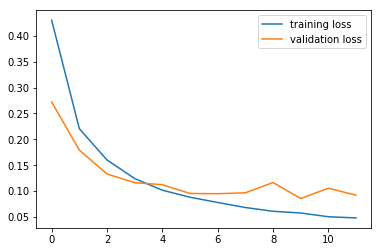

In [11]:
plt.plot(running_loss_history, label="training loss")
plt.plot(val_running_loss_history, label="validation loss")
plt.legend()

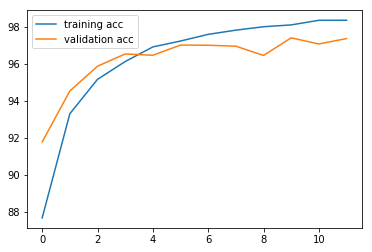

In [13]:
plt.plot(running_corrects_history, label="training acc")
plt.plot(val_running_corrects_history, label="validation acc")
plt.legend()